In [7]:
import ee, eemont
import xee, wxee
import xarray as xr

import hvplot.xarray
import holoviews as hv
import numpy as np

import os
import pandas as pd

import geopandas as gpd
import geemap
import geemap.colormaps as geecm

import matplotlib.pyplot as plt
import cmocean

In [8]:
ee.Authenticate()
ee.Initialize()

In [9]:
palette_diff = geecm.get_palette('RdBu', n_class=7)
palette_ndwi = geecm.get_palette('viridis', n_class=7)
palette_gbr = cmocean.cm.ice
palette_dem = cmocean.cm.solar
palette_slope = cmocean.cm.matter
visParams_diff = {'min': -2, 'max': 2, 'palette': palette_diff}
visParams_ndwi = {'min': 0.0, 'max': 0.5, 'palette': palette_ndwi}
visParams_gbr = {'min': 0, 'max': 10, 'palette': palette_gbr}
visParams_dem = {'min': 1000, 'max': 4000, 'palette': palette_dem}
visParams_slope = {'min': 20, 'max': 60, 'palette': palette_slope}

vis_params_landsat = {
    'bands': ['RED', 'GREEN', 'BLUE'],  # RGB
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.3
}

# 3 palettes glacier avec nuances différentes (au choix ici pour exemple)
visGLACIER_1 = {"min": 0, "max": 1, "palette": ["#808080", "#228B22"]}   # Vert forêt
visGLACIER_2 = {"min": 0, "max": 1, "palette": ["#808080", "#FF00FF"]}   # Magenta
visGLACIER_3 = {"min": 0, "max": 1, "palette": ["#808080", "#00FFFF"]}   # Cyan
visGLACIER_4 = {"min": 0, "max": 1, "palette": ["#808080", "#FF0000"]}   # Rouge vif
visWATER = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}  # Cyan → Bleu → Bleu foncé
# visWATER_2 = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}
# visWATER_3 = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}

visVEGET = {"min": 0, "max": 1, "palette": ["#808080", "#33a02c"]}

In [10]:
#Seuils Test
# 1,8 https://doi.org/10.1016/j.rse.2021.112862
GlacierThreshold_1 = 2
GlacierThreshold_2 = 3
GlacierThreshold_3 = 4
GlacierThreshold_4 = 6


In [11]:
years = range(1984, 2025)

In [12]:
#Importing TS IC

GBR_TS_filled_smooth=ee.ImageCollection([
    ee.Image(f"projects/ee-roniritzganem/assets/stage_carrtel_2025/Time_series_GBR_NDWI_TIR/GBR/GBR_TS_filled_smooth_{year}")
    for year in years
])
TIR_TS_filled_smooth=ee.ImageCollection([
    ee.Image(f"projects/ee-roniritzganem/assets/stage_carrtel_2025/Time_series_GBR_NDWI_TIR/TempC/TIR_TS_filled_smooth_{year}").set('year', year).set("system:time_start", ee.Date(f"{year}"))
    for year in years
])
NDWI_TS_filled_smooth=ee.ImageCollection([
    ee.Image(f"projects/ee-roniritzganem/assets/stage_carrtel_2025/Time_series_GBR_NDWI_TIR/NDWI/NDWI_TS_filled_smooth_{year}")
    for year in years
])

In [13]:
dem_glo30 = ee.ImageCollection("COPERNICUS/DEM/GLO30")

In [14]:
scale = 30 #Landsat 30m
projection = "EPSG:4326" #GEE le plus stable avec ce SRC

In [15]:
fc_lia = ee.FeatureCollection('users/aguerou/ice_and_life/carto_h1b/lia_shp/glaciers_1850_final_mars_2025') # demander les références

geom_alpes_FR = ee.FeatureCollection('users/aguerou/ice_and_life/erable_2025/data_ancillary/alpes_francaises')

geom_RGI_2000=ee.FeatureCollection('projects/sat-io/open-datasets/RGI/RGI_VECTOR_MERGED_V7')
geom_RGI_2015=ee.FeatureCollection('users/aguerou/ice_and_life/carto_h1b/lia_shp/c3s_gi_rgi11_s2_2015_v2')

In [16]:
geom_RGI_FR_2000=ee.FeatureCollection('projects/ee-roniritzganem/assets/stage_carrtel_2025/RGI/RGI_FR_2000')
geom_RGI_FR_2015=ee.FeatureCollection('projects/ee-roniritzganem/assets/stage_carrtel_2025/RGI/RGI_FR_2015')
geom_lia = ee.Geometry.convexHull(fc_lia.geometry())

# EVALUATION AFTER PROCESSING

In [17]:
def classifyGlacier(image, seuil):
    temp = image.select('GBR').gt(seuil)
    mask = temp.where(temp.gte(1), 1)
    return image.addBands(mask.rename('GLACIER').toInt())

In [18]:
def generate_seuil_for_years(year_selected,Threshold):
   # Sélection de l'image annuelle
    image_annee = (GBR_TS_filled_smooth
                   .filter(ee.Filter.eq('year', year_selected))
                   .first())
    
    image_finale = ee.ImageCollection(image_annee)
    
    # Traitement pour chaque seuil
    Seuil = image_finale.map(lambda image: classifyGlacier(image, Threshold))\
                        .map(lambda img: img.selfMask())
    
    # Sélection des bandes utiles
    Seuil_selected = Seuil.select(['GLACIER'])

     # Conversion en image unique par seuil (mosaic)
    aire_threshold = Seuil_selected.mosaic()
    
    return aire_threshold

In [19]:
def evaluer_seuils_glaciers(year_selected, rgi_geom, aire_threshold):
    # Calcul de la surface pour chaque feature du RGI
    rgi_with_area = rgi_geom.map(
        lambda feature: feature.set(
            {'areakm²': feature.geometry().area().divide(1e6)}))  # m² -> km²

    # Surface totale du RGI
    surface_totale_rgi = rgi_with_area.aggregate_sum('areakm²')

    # Images des seuils pour l'année sélectionnée (supposées préchargées)

    # Surface dans le RGI
    glacier_in_rgi = aire_threshold.clip(rgi_geom).select('GLACIER') \
        .multiply(ee.Image.pixelArea()) \
        .reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geom_lia,
                scale=30,
                crs=projection,
                maxPixels=1e9
            ).getNumber('GLACIER').divide(1e6)

    # Surface totale (dans toute la zone d’étude)
    glacier_total = aire_threshold.select('GLACIER') \
            .multiply(ee.Image.pixelArea()) \
            .reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=geom_lia,
                scale=30,
                crs=projection,
                maxPixels=1e9
            ).getNumber('GLACIER').divide(1e6)

    # Surface hors RGI, normalisée
    commission_error = (1-(glacier_in_rgi.divide(glacier_total)))*100 # le mieux est le plus proche de 0

        # Accuracy (recouvrement avec le RGI)
    completude = glacier_in_rgi.divide(surface_totale_rgi).multiply(100)

    # Retourne les résultats sous forme de dictionnaires
    return commission_error, completude

In [20]:
def afficher_carte_seuils(year_selected):

    Map = geemap.Map(center=[45.9, 6.8], zoom=7)
    Map.setCenter(6.5, 45.5, 8)

    Map.addLayer(fc_lia, {}, 'LIA')
    Map.add_basemap('SATELLITE')
    Map.layers[-1].opacity = 0.5

    #Map.addLayer(Landsat_processed_2000, vis_params_landsat, f'Landsat {year_selected} - Moyenne août {year_selected}')

    Map.addLayer(geom_RGI_FR_2000.style(color='blue', width=1), {}, 'RGI 2000 FR')
    Map.addLayer(geom_RGI_FR_2015.style(color='white', width=1),{}, 'RGI 2015 FR')


    
    for i in range(1, 5):
        threshold_value = globals()[f"GlacierThreshold_{i}"]  
        seuil_image = generate_seuil_for_years(year_selected, threshold_value)
        vis = globals()[f"visGLACIER_{i}"]
    
        vector = seuil_image.select('GLACIER').reduceToVectors(
            geometryType='polygon',
            reducer=ee.Reducer.countEvery(),
            scale=30,
            geometry=geom_lia,
            labelProperty='zone',
            maxPixels=1e13
            ).style(**{
            'color': vis['palette'][1],
            'fillColor': '00000000',
            'width': 1
             })

        #Map.addLayer(vector, {}, f'Glacier_Seuil_{i} - Contours')
        Map.addLayer(seuil_image.select('GLACIER'), vis, f'Glacier_Seuil{i}')

    Map.addLayer(geom_RGI_FR_2000.style(color='blue', width=1), {}, 'RGI 2000 FR_bis')
    Map.addLayer(geom_RGI_FR_2015.style(color='white', width=1),{}, 'RGI 2015 FR_bis')
    
    return Map

In [21]:
Seuil1_2000=generate_seuil_for_years(2000,GlacierThreshold_1)
Seuil2_2000=generate_seuil_for_years(2000,GlacierThreshold_2)
Seuil3_2000=generate_seuil_for_years(2000,GlacierThreshold_3)
Seuil4_2000=generate_seuil_for_years(2000,GlacierThreshold_4)


In [22]:
Seuil1_2015=generate_seuil_for_years(2015,GlacierThreshold_1)
Seuil2_2015=generate_seuil_for_years(2015,GlacierThreshold_2)
Seuil3_2015=generate_seuil_for_years(2015,GlacierThreshold_3)
Seuil4_2015=generate_seuil_for_years(2015,GlacierThreshold_4)

In [23]:
# Liste des seuils avec leur valeur de seuil utilisée
years_studied=[2000,2015]

seuils_2015 = [
    (GlacierThreshold_1, Seuil1_2015),
    (GlacierThreshold_2, Seuil2_2015),
    (GlacierThreshold_3, Seuil3_2015),
    (GlacierThreshold_4, Seuil4_2015)
]

seuils_2000 = [
    (GlacierThreshold_1, Seuil1_2000),
    (GlacierThreshold_2, Seuil2_2000),
    (GlacierThreshold_3, Seuil3_2000),
    (GlacierThreshold_4, Seuil4_2000)
]

# Initialisation des résultats
resultats = []

# Boucle pour 2015
for seuil_valeur, seuil_objet in seuils_2015:
    commission_error, completude = evaluer_seuils_glaciers("2015", geom_RGI_FR_2015, seuil_objet)
    resultats.append({
        "Année": 2015,
        "Seuil (valeur)": seuil_valeur,
        "Commission (%)": commission_error.getInfo(),
        "Complétude (%)": completude.getInfo()
    })

# Boucle pour 2000
for seuil_valeur, seuil_objet in seuils_2000:
    commission_error, completude = evaluer_seuils_glaciers("2000", geom_RGI_FR_2000, seuil_objet)
    resultats.append({
        "Année": 2000,
        "Seuil (valeur)": seuil_valeur,
        "Commission (%)": commission_error.getInfo(),
        "Complétude (%)": completude.getInfo()
    })


# Création du DataFrame à partir des résultats existants
df_flat = pd.DataFrame(resultats)

# Pivot pour avoir une structure à colonnes multiples
df_pivot = df_flat.pivot(index="Seuil (valeur)", columns="Année", values=["Commission (%)", "Complétude (%)"])

# Réorganiser pour que l'année soit au premier niveau
df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1, level=0)

# Calcul manuel des moyennes par seuil sur les deux années
df_moyennes = df_pivot.groupby(level=1, axis=1).mean()

# Ajouter les colonnes 'Moyenne' dans le multi-index
df_pivot[("Moyenne", "Commission (%)")] = df_moyennes["Commission (%)"]
df_pivot[("Moyenne", "Complétude (%)")] = df_moyennes["Complétude (%)"]

# Réordonner les colonnes pour avoir "Moyenne" à la fin
df_pivot = df_pivot.sort_index(axis=1, level=0)

# Affichage
print("                Évaluation des seuils pour les années 2000 et 2015")
print(df_pivot)

                Évaluation des seuils pour les années 2000 et 2015
Année                    2000                          2015                 \
               Commission (%) Complétude (%) Commission (%) Complétude (%)   
Seuil (valeur)                                                               
2                   31.652715      87.954619      39.526408      90.856105   
3                   23.689372      85.092347      29.099916      88.237042   
4                   18.679836      82.494686      22.727359      85.939633   
6                   12.287793      77.828209      14.935012      81.605328   

Année                 Moyenne                 
               Commission (%) Complétude (%)  
Seuil (valeur)                                
2                   35.589562      89.405362  
3                   26.394644      86.664695  
4                   20.703597      84.217159  
6                   13.611402      79.716768  


C:\Users\ronir\AppData\Local\Temp\ipykernel_8664\2922117163.py:52: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_moyennes = df_pivot.groupby(level=1, axis=1).mean()


In [24]:
# Données extraites du screenshot (avant traitement)
df_avant_traitement = pd.DataFrame({
    "Seuil (valeur)": [2, 3, 4, 6],
    "Commission (%) 2000": [21.610372, 14.914052, 11.384031, 7.424047],
    "Complétude (%) 2000": [84.506628, 80.658883, 77.719197, 72.856465],
    "Commission (%) 2015": [12.227857, 7.472952, 5.348809, 3.144183],
    "Complétude (%) 2015": [82.492100, 78.115969, 74.799213, 69.231262],
    "Commission Moyenne (%)": [16.919114, 11.193502, 8.366420, 5.284115],
    "Complétude Moyenne (%)": [83.499364, 79.386976, 76.259205, 71.043864]
})

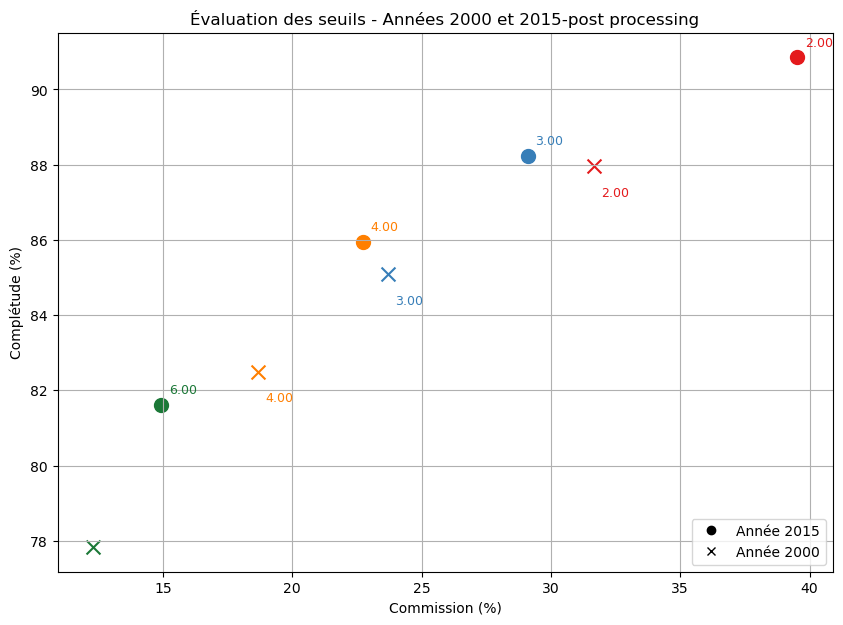

In [25]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Séparer les résultats par année
df_2015 = df_flat[df_flat["Année"] == 2015].reset_index(drop=True)
df_2000 = df_flat[df_flat["Année"] == 2000].reset_index(drop=True)

couleurs_seuils = {
    0: '#e41a1c',  # rouge
    1: '#377eb8',  # bleu
    2: '#ff7f00',  # orange
    3: '#1b7837'   # vert foncé
}

# Création de la figure
plt.figure(figsize=(10, 7))

# Points 2015 (ronds)
for idx, row in df_2015.iterrows():
    seuil = row["Seuil (valeur)"]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    color = couleurs_seuils[idx]
    plt.scatter(x, y, color=color, marker='o', s=100)
    plt.annotate(f"{seuil:.2f}", (x + 0.3, y + 0.3), fontsize=9, color=color)

# Points 2000 (croix)
for idx, row in df_2000.iterrows():
    seuil = row["Seuil (valeur)"]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    color = couleurs_seuils[idx]
    plt.scatter(x, y, color=color, marker='x', s=100)
    plt.annotate(f"{seuil:.2f}", (x + 0.3, y - 0.8), fontsize=9, color=color)

# Axes et titre
plt.ylabel("Complétude (%)")
plt.xlabel("Commission (%)")
plt.title("Évaluation des seuils - Années 2000 et 2015-post processing")
plt.grid(True)
# plt.gca().invert_xaxis()

# Légende 
legend_elements = [
    Line2D([0], [0], marker='o', color='black', label='Année 2015', linestyle='None'),
    Line2D([0], [0], marker='x', color='black', label='Année 2000', linestyle='None')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.show()

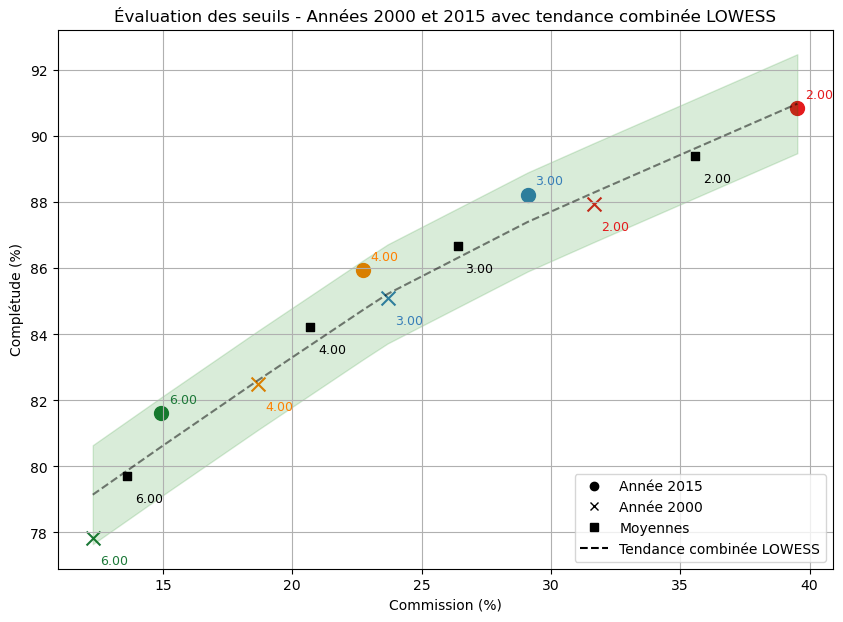

In [26]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# Séparer les résultats par année
df_2015 = df_flat[df_flat["Année"] == 2015].reset_index(drop=True)
df_2000 = df_flat[df_flat["Année"] == 2000].reset_index(drop=True)

couleurs_seuils = {
    0: '#e41a1c',  # rouge
    1: '#377eb8',  # bleu
    2: '#ff7f00',  # orange
    3: '#1b7837'   # vert foncé
}

plt.figure(figsize=(10, 7))

# Tracer les points et annotations
for idx, row in df_2015.iterrows():
    seuil = row["Seuil (valeur)"]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    color = couleurs_seuils[idx]
    plt.scatter(x, y, color=color, marker='o', s=100)
    plt.annotate(f"{seuil:.2f}", (x + 0.3, y + 0.3), fontsize=9, color=color)

for idx, row in df_2000.iterrows():
    seuil = row["Seuil (valeur)"]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    color = couleurs_seuils[idx]
    plt.scatter(x, y, color=color, marker='x', s=100)
    plt.annotate(f"{seuil:.2f}", (x + 0.3, y - 0.8), fontsize=9, color=color)

# Fusionner les deux DataFrames pour les années 2000 et 2015 sur le seuil
df_combined = pd.merge(df_2000[['Seuil (valeur)', 'Commission (%)', 'Complétude (%)']], 
                       df_2015[['Seuil (valeur)', 'Commission (%)', 'Complétude (%)']], 
                       on="Seuil (valeur)", suffixes=('_2000', '_2015'))

# Calcul des moyennes par seuil pour chaque année (2000 et 2015)
df_combined['Commission Moyenne'] = df_combined[['Commission (%)_2000', 'Commission (%)_2015']].mean(axis=1)
df_combined['Complétude Moyenne'] = df_combined[['Complétude (%)_2000', 'Complétude (%)_2015']].mean(axis=1)

# Combine les données de 2000 et 2015 pour calculer la courbe de tendance centrée
x_combined = np.concatenate([df_2015["Commission (%)"].values, df_2000["Commission (%)"].values])
y_combined = np.concatenate([df_2015["Complétude (%)"].values, df_2000["Complétude (%)"].values])

# LOWESS pour les points combinés, avec une transparence de 0.5 et une bande autour de la tendance
lowess_combined = lowess(y_combined, x_combined, frac=1)

# Tracer la courbe de tendance combinée
plt.plot(lowess_combined[:, 0], lowess_combined[:, 1], color='black', linestyle='--', alpha=0.5, label='Tendance combinée LOWESS')

# Calculer l'enveloppe autour de la courbe (min et max autour de la courbe)
y_min = lowess_combined[:, 1] - 1.5  # Enveloppe inférieure (±1%)
y_max = lowess_combined[:, 1] + 1.5  # Enveloppe supérieure (±1%)

# Tracer l'enveloppe
plt.fill_between(lowess_combined[:, 0], y_min, y_max, color='green', alpha=0.15, label='Enveloppe de tendance ±1%')

# Ajouter les points moyens en carré non rempli et deux fois plus petit pour chaque seuil
for _, row in df_combined.iterrows():
    # Moyenne pour le seuil
    mean_x = row['Commission Moyenne']
    mean_y = row['Complétude Moyenne']
    seuil = row['Seuil (valeur)']  # Récupérer la valeur du seuil pour chaque itération

    # Tracer le point carré non rempli
    plt.scatter(mean_x, mean_y, color='black', marker='s', s=30, edgecolors='black')

    # Ajouter l'annotation du seuil à côté du point moyen
    plt.annotate(f"{seuil:.2f}", (mean_x + 0.3, mean_y - 0.8), fontsize=9, color='black')
# Axes et titre
plt.ylabel("Complétude (%)")
plt.xlabel("Commission (%)")
plt.title("Évaluation des seuils - Années 2000 et 2015 avec tendance combinée LOWESS")
plt.grid(True)

# Ajouter les éléments de légende pour chaque type
legend_elements = [
    Line2D([0], [0], marker='o', color='black', label='Année 2015', linestyle='None'),
    Line2D([0], [0], marker='x', color='black', label='Année 2000', linestyle='None'),
    Line2D([0], [0], marker='s', color='black', label='Moyennes', linestyle='None'),
    Line2D([0], [0], marker='', color='black', label='Tendance combinée LOWESS', linestyle='--')
]

# Afficher la légende
plt.legend(handles=legend_elements, loc='lower right')

# Afficher le graphique
plt.show()

C:\Users\ronir\AppData\Local\Temp\ipykernel_8664\1649412674.py:64: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(df_avant_traitement["Commission Moyenne (%)"], df_avant_traitement["Complétude Moyenne (%)"],


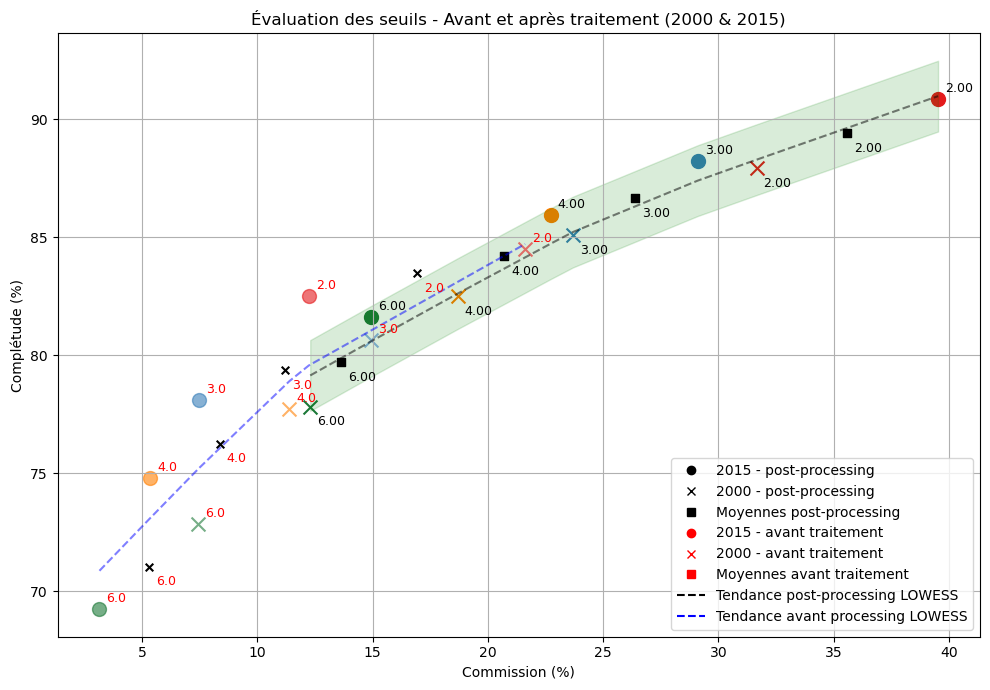

In [27]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# Recréation de tes DataFrames post-processing
df_2015 = df_flat[df_flat["Année"] == 2015].reset_index(drop=True)
df_2000 = df_flat[df_flat["Année"] == 2000].reset_index(drop=True)

couleurs_seuils = {
    0: '#e41a1c',  # rouge
    1: '#377eb8',  # bleu
    2: '#ff7f00',  # orange
    3: '#1b7837'   # vert foncé
}

plt.figure(figsize=(10, 7))

# Tracer les points post-processing
for idx, row in df_2015.iterrows():
    seuil = row["Seuil (valeur)"]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    color = couleurs_seuils[idx]
    plt.scatter(x, y, color=color, marker='o', s=100)
    plt.annotate(f"{seuil:.2f}", (x + 0.3, y + 0.3), fontsize=9, color='black')

for idx, row in df_2000.iterrows():
    seuil = row["Seuil (valeur)"]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    color = couleurs_seuils[idx]
    plt.scatter(x, y, color=color, marker='x', s=100)
    plt.annotate(f"{seuil:.2f}", (x + 0.3, y - 0.8), fontsize=9, color='black')

# Fusion post-processing
df_combined = pd.merge(df_2000[['Seuil (valeur)', 'Commission (%)', 'Complétude (%)']], 
                       df_2015[['Seuil (valeur)', 'Commission (%)', 'Complétude (%)']], 
                       on="Seuil (valeur)", suffixes=('_2000', '_2015'))

df_combined['Commission Moyenne'] = df_combined[['Commission (%)_2000', 'Commission (%)_2015']].mean(axis=1)
df_combined['Complétude Moyenne'] = df_combined[['Complétude (%)_2000', 'Complétude (%)_2015']].mean(axis=1)

# LOWESS post-processing
x_combined = np.concatenate([df_2015["Commission (%)"], df_2000["Commission (%)"]])
y_combined = np.concatenate([df_2015["Complétude (%)"], df_2000["Complétude (%)"]])
lowess_combined = lowess(y_combined, x_combined, frac=1)
plt.plot(lowess_combined[:, 0], lowess_combined[:, 1], color='black', linestyle='--', alpha=0.5, label='Tendance post-processing LOWESS')
plt.fill_between(lowess_combined[:, 0], lowess_combined[:, 1]-1.5, lowess_combined[:, 1]+1.5, color='green', alpha=0.15, label='Enveloppe ±1% (post)')

# Points moyens post-processing
for _, row in df_combined.iterrows():
    plt.scatter(row['Commission Moyenne'], row['Complétude Moyenne'], color='black', marker='s', s=30, edgecolors='black')
    plt.annotate(f"{row['Seuil (valeur)']:.2f}", (row['Commission Moyenne'] + 0.3, row['Complétude Moyenne'] - 0.8), fontsize=9, color='black')

# Points avant traitement
for i, row in df_avant_traitement.iterrows():
    plt.scatter(row["Commission (%) 2015"], row["Complétude (%) 2015"], color=couleurs_seuils[i], marker='o', s=100, alpha=0.6)
    plt.scatter(row["Commission (%) 2000"], row["Complétude (%) 2000"], color=couleurs_seuils[i], marker='x', s=100, alpha=0.6)
    plt.annotate(f"{row['Seuil (valeur)']}", (row["Commission (%) 2000"] + 0.3, row["Complétude (%) 2000"] + 0.3), fontsize=9, color='red')
    plt.annotate(f"{row['Seuil (valeur)']}", (row["Commission (%) 2015"] + 0.3, row["Complétude (%) 2015"] + 0.3), fontsize=9, color='red')

# Points moyens avant traitement
plt.scatter(df_avant_traitement["Commission Moyenne (%)"], df_avant_traitement["Complétude Moyenne (%)"], 
            color='black', marker='x', s=30, edgecolors='black', label="Moyennes pre traitement")
for i, row in df_avant_traitement.iterrows():
    plt.annotate(f"{row['Seuil (valeur)']}", (row["Commission Moyenne (%)"] + 0.3, row["Complétude Moyenne (%)"] - 0.8), fontsize=9, color='red')

# LOWESS avant traitement
x_avant = np.concatenate([df_avant_traitement["Commission (%) 2000"], df_avant_traitement["Commission (%) 2015"]])
y_avant = np.concatenate([df_avant_traitement["Complétude (%) 2000"], df_avant_traitement["Complétude (%) 2015"]])
lowess_avant = lowess(y_avant, x_avant, frac=1)
plt.plot(lowess_avant[:, 0], lowess_avant[:, 1], color='blue', linestyle='--', alpha=0.5, label='Tendance avant processing LOWESS')

# Mise en forme du graphique
plt.xlabel("Commission (%)")
plt.ylabel("Complétude (%)")
plt.title("Évaluation des seuils - Avant et après traitement (2000 & 2015)")
plt.grid(True)

# Légende mise à jour
legend_elements = [
    Line2D([0], [0], marker='o', color='black', label='2015 - post-processing', linestyle='None'),
    Line2D([0], [0], marker='x', color='black', label='2000 - post-processing', linestyle='None'),
    Line2D([0], [0], marker='s', color='black', label='Moyennes post-processing', linestyle='None'),
    Line2D([0], [0], marker='o', color='red', label='2015 - avant traitement', linestyle='None'),
    Line2D([0], [0], marker='x', color='red', label='2000 - avant traitement', linestyle='None'),
    Line2D([0], [0], marker='s', color='red', label='Moyennes avant traitement', linestyle='None'),
    Line2D([0], [0], color='black', linestyle='--', label='Tendance post-processing LOWESS'),
    Line2D([0], [0], color='blue', linestyle='--', label='Tendance avant processing LOWESS')
]

plt.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

C:\Users\ronir\AppData\Local\Temp\ipykernel_8664\3801783643.py:59: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(df_avant_traitement["Commission Moyenne (%)"], df_avant_traitement["Complétude Moyenne (%)"],


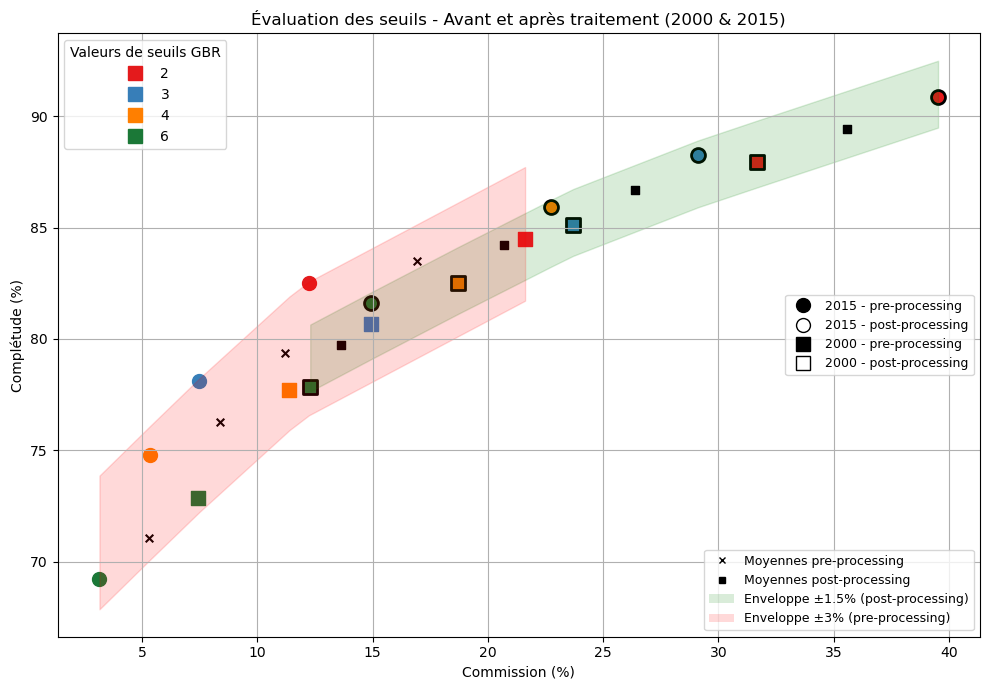

In [28]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# Recréation des DataFrames post-processing
df_2015 = df_flat[df_flat["Année"] == 2015].reset_index(drop=True)
df_2000 = df_flat[df_flat["Année"] == 2000].reset_index(drop=True)

# Couleurs des seuils
couleurs_seuils = {
    0: '#e41a1c',  # rouge
    1: '#377eb8',  # bleu
    2: '#ff7f00',  # orange
    3: '#1b7837'   # vert foncé
}
valeur_seuils = [2, 3, 4, 6]

# Créer figure et axes
fig, ax = plt.subplots(figsize=(10, 7))

# Tracer les points post-processing
for idx, row in df_2015.iterrows():
    color = couleurs_seuils[idx]
    ax.scatter(row["Commission (%)"], row["Complétude (%)"], color=color, marker='o', s=100, label='_nolegend_', edgecolors='black', linewidth=2)

for idx, row in df_2000.iterrows():
    color = couleurs_seuils[idx]
    ax.scatter(row["Commission (%)"], row["Complétude (%)"], color=color, marker='s', s=100, label='_nolegend_', edgecolors='black', linewidth=2)

# Fusion des deux années
df_combined = pd.merge(
    df_2000[['Seuil (valeur)', 'Commission (%)', 'Complétude (%)']],
    df_2015[['Seuil (valeur)', 'Commission (%)', 'Complétude (%)']],
    on="Seuil (valeur)", suffixes=('_2000', '_2015'))

df_combined['Commission Moyenne'] = df_combined[['Commission (%)_2000', 'Commission (%)_2015']].mean(axis=1)
df_combined['Complétude Moyenne'] = df_combined[['Complétude (%)_2000', 'Complétude (%)_2015']].mean(axis=1)

# LOWESS post-processing
x_combined = np.concatenate([df_2015["Commission (%)"], df_2000["Commission (%)"]])
y_combined = np.concatenate([df_2015["Complétude (%)"], df_2000["Complétude (%)"]])
lowess_combined = lowess(y_combined, x_combined, frac=1)
ax.fill_between(lowess_combined[:, 0], lowess_combined[:, 1]-1.5, lowess_combined[:, 1]+1.5,
                color='green', alpha=0.15, label='_nolegend_')

# Points moyens post-processing
ax.scatter(df_combined['Commission Moyenne'], df_combined['Complétude Moyenne'],
           color='black', marker='s', s=30, edgecolors='black', label='_nolegend_')

# Points avant traitement
for i, row in df_avant_traitement.iterrows():
    color = couleurs_seuils[i]
    ax.scatter(row["Commission (%) 2015"], row["Complétude (%) 2015"], color=color, marker='o', s=100, alpha=1, label='_nolegend_')
    ax.scatter(row["Commission (%) 2000"], row["Complétude (%) 2000"], color=color, marker='s', s=100, alpha=1, label='_nolegend_')

# Moyennes avant traitement
ax.scatter(df_avant_traitement["Commission Moyenne (%)"], df_avant_traitement["Complétude Moyenne (%)"],
           color='black', marker='x', s=30, edgecolors='black', label='_nolegend_')

# LOWESS avant traitement
x_avant = np.concatenate([df_avant_traitement["Commission (%) 2000"], df_avant_traitement["Commission (%) 2015"]])
y_avant = np.concatenate([df_avant_traitement["Complétude (%) 2000"], df_avant_traitement["Complétude (%) 2015"]])
lowess_avant = lowess(y_avant, x_avant, frac=1)
ax.fill_between(lowess_avant[:, 0], lowess_avant[:, 1]-3, lowess_avant[:, 1]+3,
                color='red', alpha=0.15, label='_nolegend_')

# Mise en forme
ax.set_xlabel("Commission (%)")
ax.set_ylabel("Complétude (%)")
ax.set_title("Évaluation des seuils - Avant et après traitement (2000 & 2015)")
ax.grid(True)

# --- Légendes ---

# Légende des couleurs des seuils
legende_seuils = [
    Line2D([0], [0], marker='s', color=color, linestyle='None', markersize=10, label=valeur_seuils[i])
    for i, color in couleurs_seuils.items()
]
legend1 = ax.legend(handles=legende_seuils, loc='upper left', title="Valeurs de seuils GBR", frameon=True)
ax.add_artist(legend1)

# Légende des moyennes & enveloppes
legend_2 = [
    Line2D([0], [0], marker='x', color='black', label='Moyennes pre-processing', linestyle='None', markersize=5),
    Line2D([0], [0], marker='s', color='black', label='Moyennes post-processing', linestyle='None', markersize=5),
    Patch(facecolor='green', alpha=0.15, edgecolor='none', label='Enveloppe ±1.5% (post-processing)'),
    Patch(facecolor='red', alpha=0.15, edgecolor='none', label='Enveloppe ±3% (pre-processing)'),
]
legend2 = ax.legend(handles=legend_2, loc='lower right', frameon=True, fontsize=9)
ax.add_artist(legend2)

# Légende symbologie
legend_elements = [
    Line2D([0], [0], marker='o', color='black', label='2015 - pre-processing', linestyle='None', markersize=10),
    Line2D([0], [0], marker='o', color='None', markeredgecolor='black', linewidth=2, label='2015 - post-processing', linestyle='None', markersize=10),
    Line2D([0], [0], marker='s', color='black', label='2000 - pre-processing', linestyle='None', markersize=10),
    Line2D([0], [0], marker='s', color='None', markeredgecolor='black', linewidth=2, label='2000 - post-processing', linestyle='None', markersize=10)
]
ax.legend(handles=legend_elements, loc='center right', frameon=True, fontsize=9)

# Affichage
plt.tight_layout()
plt.show() 

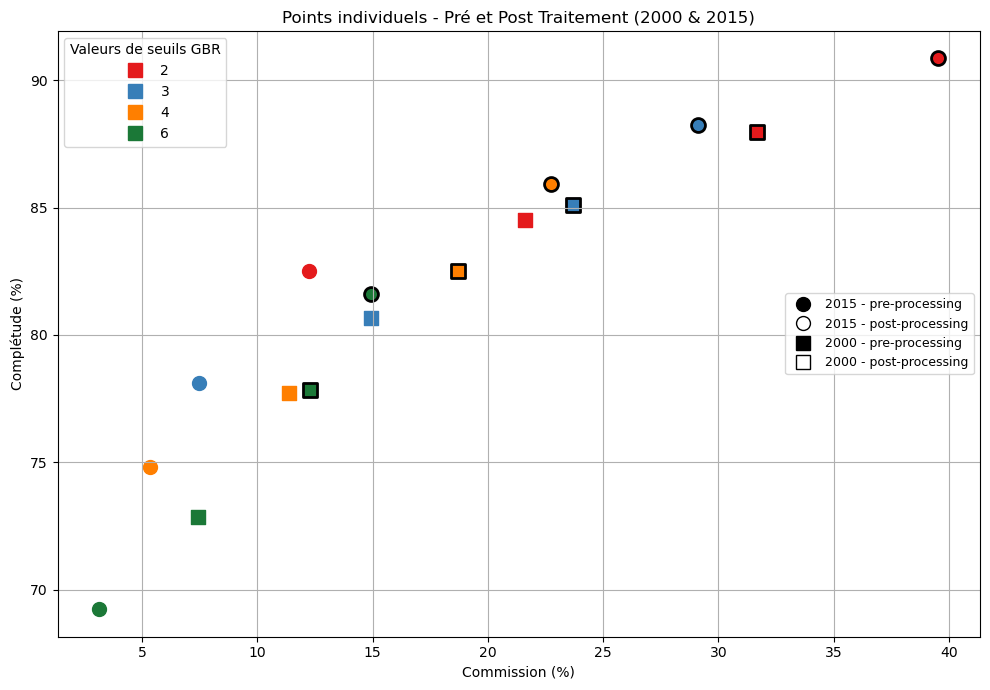

In [29]:
# --- Graphe 1 : Points individuels uniquement ---

fig, ax = plt.subplots(figsize=(10, 7))

# Points post-processing
for idx, row in df_2015.iterrows():
    color = couleurs_seuils[idx]
    ax.scatter(row["Commission (%)"], row["Complétude (%)"], color=color, marker='o', s=100, edgecolors='black', linewidth=2)

for idx, row in df_2000.iterrows():
    color = couleurs_seuils[idx]
    ax.scatter(row["Commission (%)"], row["Complétude (%)"], color=color, marker='s', s=100, edgecolors='black', linewidth=2)

# Points avant traitement
for i, row in df_avant_traitement.iterrows():
    color = couleurs_seuils[i]
    ax.scatter(row["Commission (%) 2015"], row["Complétude (%) 2015"], color=color, marker='o', s=100)
    ax.scatter(row["Commission (%) 2000"], row["Complétude (%) 2000"], color=color, marker='s', s=100)

# Mise en forme
ax.set_xlabel("Commission (%)")
ax.set_ylabel("Complétude (%)")
ax.set_title("Points individuels - Pré et Post Traitement (2000 & 2015)")
ax.grid(True)

# Légende des couleurs des seuils
legende_seuils = [
    Line2D([0], [0], marker='s', color=color, linestyle='None', markersize=10, label=valeur_seuils[i])
    for i, color in couleurs_seuils.items()
]
legend1 = ax.legend(handles=legende_seuils, loc='upper left', title="Valeurs de seuils GBR", frameon=True)
ax.add_artist(legend1)

# Légende symbologie
legend_elements = [
    Line2D([0], [0], marker='o', color='black', label='2015 - pre-processing', linestyle='None', markersize=10),
    Line2D([0], [0], marker='o', color='None', markeredgecolor='black', linewidth=2, label='2015 - post-processing', linestyle='None', markersize=10),
    Line2D([0], [0], marker='s', color='black', label='2000 - pre-processing', linestyle='None', markersize=10),
    Line2D([0], [0], marker='s', color='None', markeredgecolor='black', linewidth=2, label='2000 - post-processing', linestyle='None', markersize=10)
]
ax.legend(handles=legend_elements, loc='center right', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()


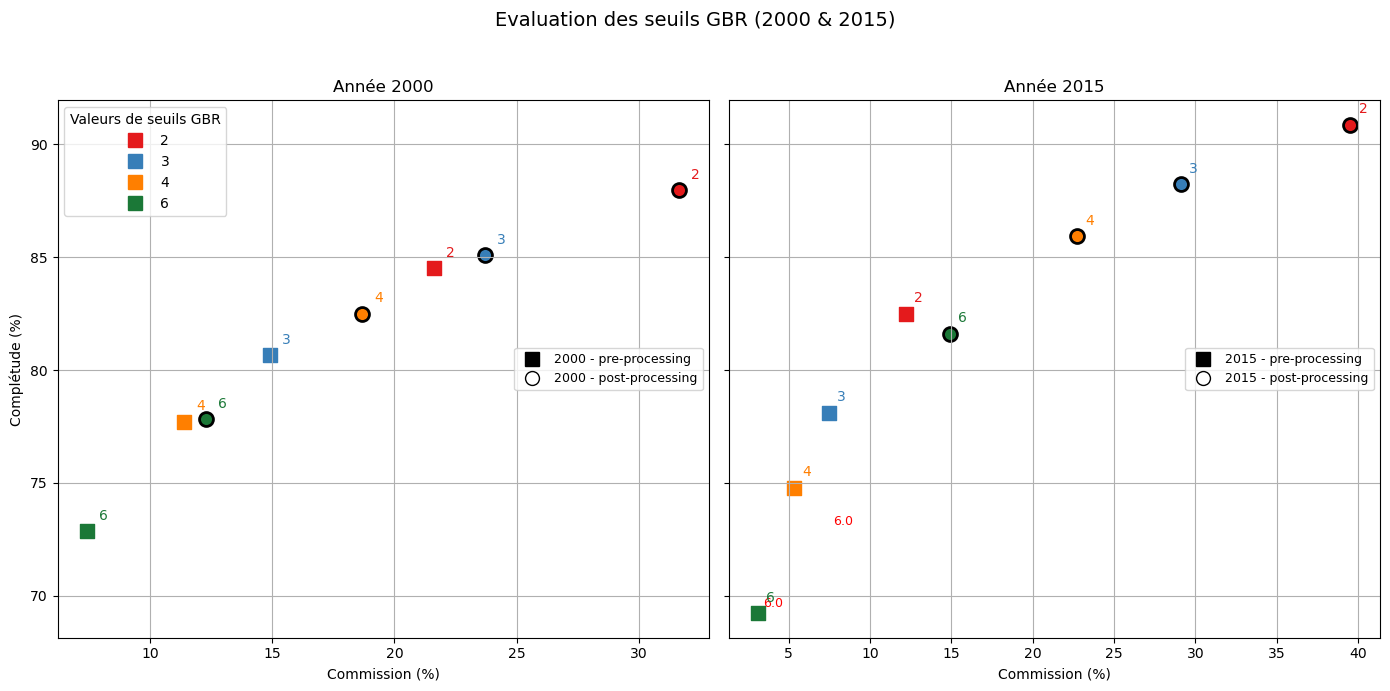

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7), sharey=True)

plt.annotate(f"{row['Seuil (valeur)']}", (row["Commission (%) 2000"] + 0.3, row["Complétude (%) 2000"] + 0.3), fontsize=9, color='red')
plt.annotate(f"{row['Seuil (valeur)']}", (row["Commission (%) 2015"] + 0.3, row["Complétude (%) 2015"] + 0.3), fontsize=9, color='red')

# --- Sous-figure pour l'année 2000 ---
for idx, row in df_2000.iterrows():
    seuil = int(row['Seuil (valeur)'])
    color = couleurs_seuils[idx]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    ax1.scatter(x, y, color=color, marker='o', s=100, edgecolors='black', linewidth=2)
    ax1.annotate(f"{seuil}", (x + 0.5, y + 0.5), fontsize=10, color=color)

for i, row in df_avant_traitement.iterrows():
    seuil = int(row['Seuil (valeur)'])
    color = couleurs_seuils[i]
    x = row["Commission (%) 2000"]
    y = row["Complétude (%) 2000"]
    ax1.scatter(x, y, color=color, marker='s', s=100)
    ax1.annotate(f"{seuil}", (x + 0.5, y + 0.5), fontsize=10, color=color)

# --- Sous-figure pour l'année 2015 ---
for idx, row in df_2015.iterrows():
    seuil = int(row['Seuil (valeur)'])
    color = couleurs_seuils[idx]
    x = row["Commission (%)"]
    y = row["Complétude (%)"]
    ax2.scatter(x, y, color=color, marker='o', s=100, edgecolors='black', linewidth=2)
    ax2.annotate(f"{seuil}", (x + 0.5, y + 0.5), fontsize=10, color=color)

for i, row in df_avant_traitement.iterrows():
    seuil = int(row['Seuil (valeur)'])
    color = couleurs_seuils[i]
    x = row["Commission (%) 2015"]
    y = row["Complétude (%) 2015"]
    ax2.scatter(x, y, color=color, marker='s', s=100)
    ax2.annotate(f"{seuil}", (x + 0.5, y + 0.5), fontsize=10, color=color)
    
ax1.set_title("Année 2000")
ax1.set_xlabel("Commission (%)")
ax1.set_ylabel("Complétude (%)")
ax1.grid(True)

ax2.set_title("Année 2015")
ax2.set_xlabel("Commission (%)")
ax2.grid(True)

# --- Légendes ---
# Couleurs des seuils
legende_seuils = [
    Line2D([0], [0], marker='s', color=color, linestyle='None', markersize=10, label=valeur_seuils[i])
    for i, color in couleurs_seuils.items()
]
legend1 = ax1.legend(handles=legende_seuils, loc='upper left', title="Valeurs de seuils GBR", frameon=True)
ax1.add_artist(legend1)

# Symbologie
legend_elements1 = [
    Line2D([0], [0], marker='s', color='black', label='2015 - pre-processing', linestyle='None', markersize=10),
    Line2D([0], [0], marker='o', color='None', markeredgecolor='black', linewidth=2, label='2015 - post-processing', linestyle='None', markersize=10),
]

legend_elements2 = [
    Line2D([0], [0], marker='s', color='black', label='2000 - pre-processing', linestyle='None', markersize=10),
    Line2D([0], [0], marker='o', color='None', markeredgecolor='black', linewidth=2, label='2000 - post-processing', linestyle='None', markersize=10)
]
ax1.legend(handles=legend_elements2, loc='center right', frameon=True, fontsize=9)
ax2.legend(handles=legend_elements1, loc='center right', frameon=True, fontsize=9)

# # Zone "Seuils Compromis" (rectangle rouge semi-transparent)
# plt.gca().add_patch(plt.Rectangle((0, 70), 10, 20, color='red', alpha=0.15, label='Seuils Compromis'))

# # Zone "Seuils Complets" (rectangle bleu semi-transparent)
# plt.gca().add_patch(plt.Rectangle((0, 80), 40, 15, color='blue', alpha=0.15, label='Seuils Complets'))


plt.suptitle("Evaluation des seuils GBR (2000 & 2015)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

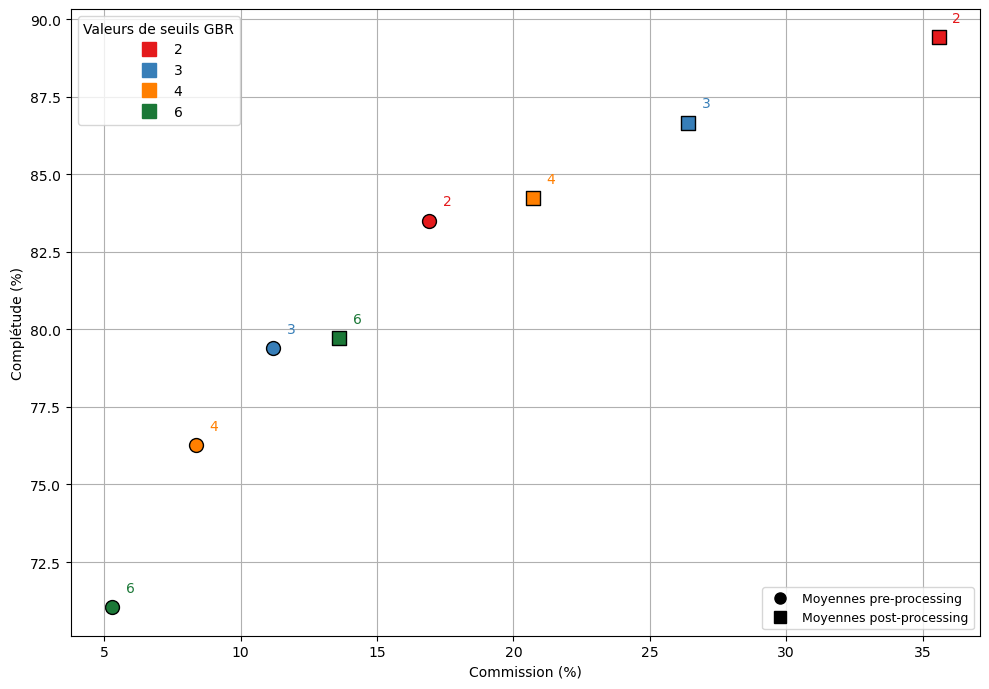

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))

# # LOWESS post-processing
# x_combined = np.concatenate([df_2015["Commission (%)"], df_2000["Commission (%)"]])
# y_combined = np.concatenate([df_2015["Complétude (%)"], df_2000["Complétude (%)"]])
# lowess_combined = lowess(y_combined, x_combined, frac=1)
# ax.fill_between(lowess_combined[:, 0], lowess_combined[:, 1] + 1, lowess_combined[:, 1]-1,
#                 color='green', alpha=0.15)

# Moyennes post-processing
for idx, row in df_combined.iterrows():
    seuil = int(row['Seuil (valeur)'])
    color = couleurs_seuils[idx]
    x = row['Commission Moyenne']
    y = row['Complétude Moyenne']
    ax.scatter(x, y, color=color, marker='s', s=100, edgecolors='black')
    ax.annotate(f"{seuil}", (x + 0.5, y + 0.5), fontsize=10, color=color)

# # LOWESS pré-traitement
# x_avant = np.concatenate([df_avant_traitement["Commission (%) 2000"], df_avant_traitement["Commission (%) 2015"]])
# y_avant = np.concatenate([df_avant_traitement["Complétude (%) 2000"], df_avant_traitement["Complétude (%) 2015"]])
# lowess_avant = lowess(y_avant, x_avant, frac=1)
# ax.fill_between(lowess_avant[:, 0], lowess_avant[:, 1]+1, lowess_avant[:, 1]-1,
#                 color='red', alpha=0.15)

# Moyennes pré-traitement
for idx, row in df_avant_traitement.iterrows():
    seuil = int(valeur_seuils[idx])
    color = couleurs_seuils[idx]
    x = row["Commission Moyenne (%)"]
    y = row["Complétude Moyenne (%)"]
    ax.scatter(x, y, color=color, marker='o', s=100, edgecolors='black')
    ax.annotate(f"{seuil}", (x + 0.5, y + 0.5), fontsize=10, color=color)

# Mise en forme
ax.set_xlabel("Commission (%)")
ax.set_ylabel("Complétude (%)")
# ax.set_title("Resultats seuils GBR moyen (2000 et 2015)")
ax.grid(True)

# Légende des moyennes & enveloppes
legend_moyennes = [
    Line2D([0], [0], marker='o', color='black', label='Moyennes pre-processing', linestyle='None', markersize=8),
    Line2D([0], [0], marker='s', color='black', label='Moyennes post-processing', linestyle='None', markersize=8),
    #Patch(facecolor='green', alpha=0.15, edgecolor='none', label='Enveloppe LOWESS ±1% (post-processing)'),
    #Patch(facecolor='red', alpha=0.15, edgecolor='none', label='Enveloppe LOWESS ±1% (pre-processing)'),
]


# Couleurs des seuils
legende_seuils = [
    Line2D([0], [0], marker='s', color=color, linestyle='None', markersize=10, label=valeur_seuils[i])
    for i, color in couleurs_seuils.items()
]
legend1 = ax.legend(handles=legende_seuils, loc='upper left', title="Valeurs de seuils GBR", frameon=True)

ax.add_artist(legend1)

# Affichage des légendes
ax.legend(handles=legend_moyennes, loc='lower right', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()


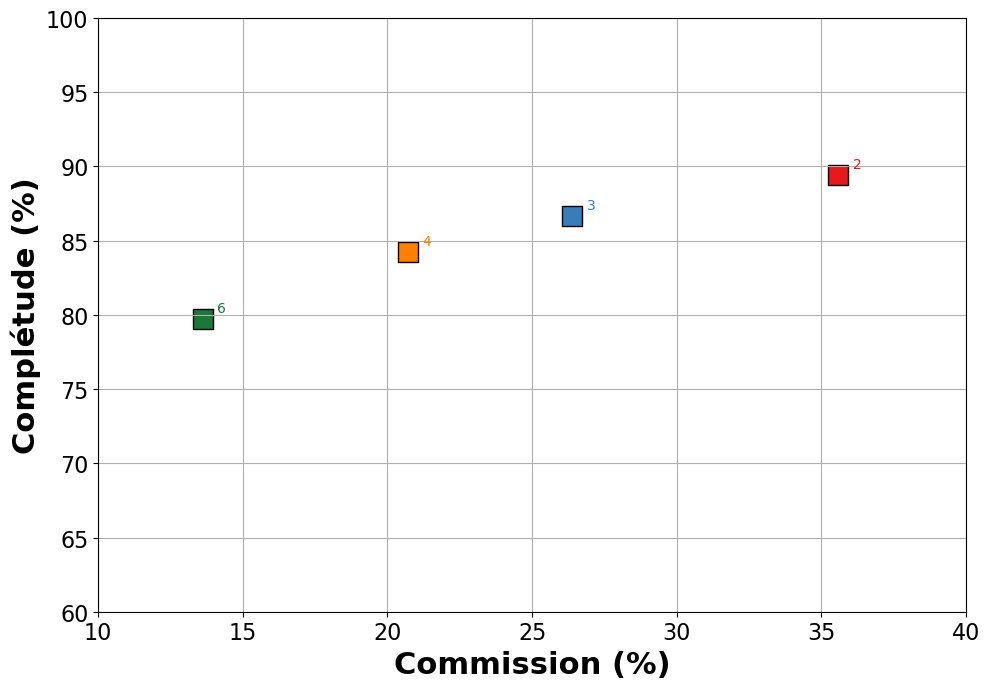

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

fig, ax = plt.subplots(figsize=(10, 7))

# Moyennes post-processing
x_vals = []
y_vals = []

for idx, row in df_combined.iterrows():
    seuil = int(row['Seuil (valeur)'])
    color = couleurs_seuils[idx]
    x = row['Commission Moyenne']
    y = row['Complétude Moyenne']
    x_vals.append(x)
    y_vals.append(y)
    ax.scatter(x, y, color=color, marker='s', s=200, edgecolors='black')  # Taille x2
    ax.annotate(f"{seuil}", (x + 0.5, y + 0.5), fontsize=10, color=color)

# # Courbe LOWESS (non linéaire)
# lowess_result = lowess(y_vals, x_vals, frac=0.1)  # Ajuste `frac` si besoin
# ax.plot(lowess_result[:, 0], lowess_result[:, 1], color='red', linewidth=1, label='Tendance (LOWESS)', alpha=0.4)

# Mise en forme des axes
ax.set_xlabel("Commission (%)", fontsize=22, fontweight='bold')
ax.set_ylabel("Complétude (%)", fontsize=22, fontweight='bold')
ax.set_xlim(10, 40)
ax.set_ylim(60, 100)
ax.tick_params(axis='both', labelsize=16)
ax.grid(True)
#ax.legend(fontsize=12)

plt.savefig('C:/Users/ronir/Desktop/Stage_Carrtel_2025/Figure_def/Rapport/Appendix/Gvalid')
plt.tight_layout()
plt.show()